## Requirements

In [ ]:
! pip install beautifulsoup4 lxml matplotlib

In [1]:
! pip install git+https://github.com/cmd-ntrf/pytesseract

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
  Cloning https://github.com/cmd-ntrf/pytesseract to /tmp/pip-req-build-95sceox7
  Running setup.py bdist_wheel for pytesseract ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-irxdjm5r/wheels/6c/00/bf/bcc188aecb111714760376905bc8a53800cc6934cbe378db3c
Successfully built pytesseract


## Initialization

In [2]:
import pyspark
sc = pyspark.SparkContext()

In [3]:
xmlfiles=sc.wholeTextFiles('/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/1860*/*.xml',64)

In [4]:
print(xmlfiles.getNumPartitions())
print(xmlfiles.count())

59
310


## Prepping on small data

In [5]:
first_xml_file = xmlfiles.first()
filename = first_xml_file[0]
newspaper_text = first_xml_file[1]
print(filename)
print(newspaper_text[:500])

file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600427/0FFO-1860-APR27.xml
<?xml version="1.0" encoding="ISO-8859-1"?>
<!DOCTYPE issue SYSTEM "LTO_issue.dtd">
<issue>
<id>0FFO-1860-APR27</id>
<jn>The Times</jn>
<ba>0FFO</ba>
<is>23605</is>
<da>April 27, 1860</da>
<pf>18600427</pf>
<ip>16</ip>
<cp>Copyright 1860, The Times</cp>
<article>
<id>0FFO-1860-APR27-001-001</id>
<ocr relevant="yes">50.89</ocr>
<sc>a</sc>
<pi pgref="1">0FFO-1860-APR27-001</pi>
<ci pgref="1" clip="1">0FFO-1860-APR27-001-001-001</ci>
<pa>1</pa>
<pc>1</pc>
<ti>Births</ti>
<ct>Bir


In [6]:
searchterm="Canada"

In [7]:
def simple_process_day(fstring):
    return fstring.count(searchterm)

In [8]:
def newsonly_process_day(fstring):
    inside_news = False
    count = 0
    for line in fstring.split("\n"):
        if "<ct>News</ct>" in line:
            inside_news = True
        if "</article>" in line:
            inside_news = False
        if inside_news:
            count += line.count(searchterm)
    return count

In [9]:
print("output", newsonly_process_day(newspaper_text))

output 1


In [10]:
import lxml
from bs4 import BeautifulSoup

In [11]:
def bs4_process_day(fstring):
    soup = BeautifulSoup(fstring, "lxml")
    count = 0
    taglist = soup.find_all("article")
    for tag in taglist:
        ct_tag = tag.find("ct")
        if ct_tag.string == "News":
            articletext = tag.find("text.cr")
            words = articletext.find_all("wd")
            for w in words:
                count += w.string.count(searchterm)
    return count

In [12]:
print("output", bs4_process_day(newspaper_text))

output 1


In [13]:
canada_counts = xmlfiles.map(lambda el: newsonly_process_day(el[1]))
canada_counts.count()

310

In [14]:
canada_counts.first()

1

In [15]:
canada_counts_withdates=xmlfiles.map(lambda el: (el[0][55:63],newsonly_process_day(el[1])))
canada_counts_withdates.take(4)

[('18600427', 1), ('18600324', 0), ('18600705', 2), ('18600612', 0)]

In [16]:
dates=canada_counts_withdates.collect()

In [17]:
import datetime

dd=datetime.date(1860,3,2)
print(dd)

1860-03-02


In [18]:
python_dates=[]
for d in dates:
    date_in_datetime=datetime.date(int(d[0][0:4]),int(d[0][4:6]),int(d[0][6:8]))
    python_dates.append((date_in_datetime,d[1]))
    
print(python_dates)

[(datetime.date(1860, 4, 27), 1), (datetime.date(1860, 3, 24), 0), (datetime.date(1860, 7, 5), 2), (datetime.date(1860, 6, 12), 0), (datetime.date(1860, 11, 27), 0), (datetime.date(1860, 7, 6), 0), (datetime.date(1860, 4, 21), 2), (datetime.date(1860, 10, 8), 1), (datetime.date(1860, 12, 29), 4), (datetime.date(1860, 5, 11), 0), (datetime.date(1860, 4, 13), 2), (datetime.date(1860, 6, 4), 1), (datetime.date(1860, 6, 18), 0), (datetime.date(1860, 4, 25), 2), (datetime.date(1860, 11, 5), 2), (datetime.date(1860, 8, 6), 2), (datetime.date(1860, 5, 26), 1), (datetime.date(1860, 6, 14), 1), (datetime.date(1860, 12, 13), 0), (datetime.date(1860, 6, 1), 0), (datetime.date(1860, 12, 15), 0), (datetime.date(1860, 10, 2), 12), (datetime.date(1860, 8, 13), 0), (datetime.date(1860, 3, 2), 7), (datetime.date(1860, 4, 2), 1), (datetime.date(1860, 5, 23), 0), (datetime.date(1860, 9, 7), 7), (datetime.date(1860, 8, 15), 1), (datetime.date(1860, 2, 7), 0), (datetime.date(1860, 8, 2), 0), (datetime.date

In [19]:
%matplotlib inline

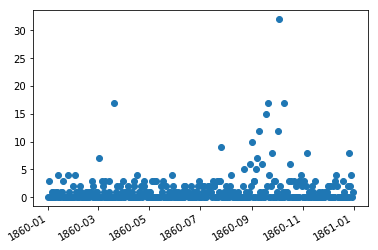

In [20]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.dates import drange
from numpy import zeros

date1 = datetime.datetime(1860,1,1)
date2 = datetime.datetime(1861,1,1)
delta = datetime.timedelta(days=1)
dates = drange(date1,date2,delta)
data=zeros(len(dates))

# fill in the data

for ele in python_dates:
    data[ele[0].toordinal()-date1.toordinal()]=ele[1]
    
fig, ax = matplotlib.pyplot.subplots()

ax.plot_date(dates,data)

fig.autofmt_xdate()

plt.show()


# Heat Map

In [21]:
f=open("/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600102/0FFO-1860-JAN02.xml",encoding="iso-8859-1")
newspaper_text=f.read()
f.close()

In [22]:
import re
searchterm="war"
def process_newspaper(whole_newspaper):
    list_of_lines=whole_newspaper.split("\n")
    
    list_positions=[]
    regEx = re.compile(r"<wd pos=\"(\d+,\d+,\d+,\d+)\">")
    for line in list_of_lines:
        if (line.lower().count(searchterm))>0:
            m = re.search(regEx,line)
            if m != None:
                list_positions.append(m.group(1))
    return list_positions
            
print(process_newspaper(newspaper_text))

['188,746,307,776', '37,2771,148,2800', '1351,1193,1638,1228', '847,1333,940,1362', '1453,1509,1602,1540', '931,1637,1107,1667', '1407,1633,1557,1664', '1303,1716,1453,1744', '1204,1881,1347,1912', '1116,1912,1439,1947', '1103,2012,1419,2049', '922,2107,1017,2140', '1150,2135,1469,2171', '3723,3807,3866,3834', '3704,3828,3807,3857', '3665,4040,3765,4070', '3269,4352,3375,4380', '1174,2261,1495,2298', '1152,2383,1483,2420', '853,2473,945,2499', '1448,2661,1539,2691', '847,3309,913,3335', '1161,5273,1284,5299', '1904,2389,2033,2418', '1984,2533,2167,2562', '2104,2619,2443,2652', '1945,4399,2081,4431', '2943,701,3053,728', '2705,1739,2914,1774', '3078,4308,3149,4340', '2804,4599,2866,4625', '2944,5162,3072,5189', '2573,5672,2713,5706', '3959,1248,4065,1278', '4430,6100,4532,6131', '118,2784,216,2815', '2708,4313,2883,4347', '3826,4311,3958,4341', '3313,4662,3362,4691', '364,4265,473,4295', '296,4520,411,4548', '466,4520,590,4552', '1275,3590,1388,3620', '1256,4902,1352,4930', '2008,565,21

In [23]:
xmlfiles=sc.wholeTextFiles('/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/1860*/*.xml',64)
#xmlfiles=sc.wholeTextFiles('/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600102/0FFO-1860-JAN02.xml')
print(xmlfiles.count())

310


In [24]:
position_data=xmlfiles.flatMap(lambda el: process_newspaper(el[1]))

In [25]:
positions=position_data.collect()

In [ ]:
import numpy as np
frontPage = np.zeros((7000,5250))
frontPage = frontPage.astype('uint32')

for p in positions:
    pos = str(p).split(",")
    posList=[int(item) for item in pos]
    frontPage[posList[1]:posList[3],posList[0]:posList[2]] += 1
    
import matplotlib.pyplot as plt
plt.figure(figsize=(200,200))
image = plt.imshow(frontPage)
plt.show()